In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
#import ARLreader as Ar
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

In [3]:
def humanbytes(B):
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1024)
   MB = float(KB ** 2) # 1,048,576
   GB = float(KB ** 3) # 1,073,741,824
   TB = float(KB ** 4) # 1,099,511,627,776

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB)

In [4]:
'''set day'''
day_date = datetime(2017,9,1)
print(day_date)

2017-09-01 00:00:00


In [5]:
'''set station'''
haifa_station = gs.Station('haifa')
#print(haifa_station)

In [6]:
'''Set paths for small tests'''
#lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
#gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'
lidar_parent_folder = haifa_station.lidar_src_folder
haifa_station.gdas1_folder = os.path.join('.','data examples','gdas')
haifa_station.gdastxt_folder  = os.path.join('.','data examples','gdas_txt')
haifa_station.molecular_src_folder =  os.path.join('.','data examples','molecular_dataset')
print(haifa_station)

<class 'global_settings.Station'>: {'name': 'haifa', 'location': 'haifa', 'lon': 35.0, 'lat': 32.8, 'altitude': 229.0, 'start_bin_height': 8.75, 'end_bin_height': 22485.66015, 'n_bins': 3000, 'dt': 5.0000000000000004e-08, 'gdas1_folder': '.\\data examples\\gdas', 'gdastxt_folder': '.\\data examples\\gdas_txt', 'lidar_src_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS', 'molecular_src_folder': '.\\data examples\\molecular_dataset', 'db_file': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\pollyxt_tropos_calibration.db'}


In [7]:
#gdas1_folder,gdas1_paths = prep.get_gdas_paths(haifa_station, day_date,'gdas1')
#print('gdas1',gdas1_paths)
'''
#convert cur day (gdas files from TROPOS to txt)

gdastxt = prep.convert_daily_gdas ( haifa_station, day_date)
print('gdas_txt',gdastxt)

#convert next day (gdas files from TROPOS to txt)
next_day = day_date + timedelta ( days = 1 )
gdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )
# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))
print('gdas_txt next day',gdastxt_nextday)

'''

"\n#convert cur day (gdas files from TROPOS to txt)\n\ngdastxt = prep.convert_daily_gdas ( haifa_station, day_date)\nprint('gdas_txt',gdastxt)\n\n#convert next day (gdas files from TROPOS to txt)\nnext_day = day_date + timedelta ( days = 1 )\ngdastxt_nextday = prep.convert_daily_gdas ( haifa_station, next_day )\n# gdastxt.extend(prep.convert_daily_gdas ( next_day , haifa_station ))\nprint('gdas_txt next day',gdastxt_nextday)\n\n"

In [8]:
'''set parameters'''
'''lambda_nm = gs.LAMBDA_nm().G
df_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )
# Visualizing molecular profiles

plt.figure()
ax = df_beta.plot()
ax.set_ylabel(r'$\beta_{\rm mol}[1/m]$')
plt.show()
'''

"lambda_nm = gs.LAMBDA_nm().G\ndf_sigma , df_beta = prep.get_daily_molecular_profiles( haifa_station , day_date , lambda_nm , 'Km' )\n# Visualizing molecular profiles\n\nplt.figure()\nax = df_beta.plot()\nax.set_ylabel(r'$\x08eta_{\rm mol}[1/m]$')\nplt.show()\n"

In [ ]:
def generate_daily_molecular_chan(station, day_date, lambda_nm, time_res='30S',
                                  height_units ='Km', optim_size=False, verbose = False):
	"""
	Generating daily molecular profiles for a given channel's wavelength
	:param station: gs.station() object of the lidar station
	:param day_date: datetime.date object of the required date
	:param lambda_nm: wavelength in [nm], e.g, for green lambda_nm = 532.0 [nm]
	:param time_res: Output time resolution required. default is 30sec (according to time resolution of pollyXT measurements)
	:param height_units:  Output units of height grid in 'Km' (default) or 'm'
	:param optim_size: Boolean. False(default): the retrieved values are of type 'float64',
	                            True: the retrieved values are of type 'float'.
	:param verbose: Boolean. False(default). True: prints information regarding size optimization.
	:return: xarray.Dataset() holding 3 daily dataframes (beta,sigma,att_bsc) for a given wavelength,
	with shared dimensions( Height, Time, Wavelength)
	"""

	'''Load daily gdas profiles and convert to backscatter (beta) and extinction (sigma) profiles'''
	import xarray as xr
	df_sigma , df_beta = prep.get_daily_molecular_profiles ( station , day_date , lambda_nm , height_units )

	''' Interpolate profiles through 24 hrs'''
	interp_sigma_df=(df_sigma.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_beta_df=(df_beta.T.resample(time_res).interpolate(method='linear')[:-1]).T
	interp_sigma_df.columns.freq = None
	interp_beta_df.columns.freq = None

	'''Calculate the molecular attenuated backscatter as :  beta_mol * exp(-2*tau_mol)'''
	e_tau_df = interp_sigma_df.apply(prep.cal_e_tau_df,0,args=(haifa_station.altitude,),result_type='expand')
	att_bsc_mol_df = interp_beta_df.multiply(e_tau_df)

	''' memory size - optimization '''
	if optim_size:
		if verbose:
			print('Memory optimization - converting molecular values from double to float')
			size_beta = interp_beta_df.memory_usage(deep=True).sum()
			size_sigma = interp_sigma_df.memory_usage(deep=True).sum()
			size_att_bsc = att_bsc_mol_df.memory_usage(deep=True).sum()

		interp_beta_df = (interp_beta_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')
		interp_sigma_df = (interp_sigma_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')
		att_bsc_mol_df = (att_bsc_mol_df.select_dtypes(include = ['float64'])).\
			apply(pd.to_numeric,downcast='float')

		if verbose:
			size_beta_opt = interp_beta_df.memory_usage(deep=True).sum()
			size_sigma_opt = interp_sigma_df.memory_usage(deep=True).sum()
			size_att_bsc_opt = att_bsc_mol_df.memory_usage(deep=True).sum()
			print('Memory saved for wavelength {} beta: {:.2f}%, sigma: {:.2f}%, att_bsc:{:.2f}%'.
			      format(lambda_nm,100.0*float(size_beta-size_beta_opt)/float(size_beta),
			             100.0*float(size_sigma-size_sigma_opt)/float(size_sigma),
			             100.0*float(size_att_bsc-size_att_bsc_opt)/float(size_att_bsc)))

	''' Create molecular dataset'''
	ds_chan = xr.Dataset(
        data_vars   =   {  'beta'   :   (('Height', 'Time'), interp_beta_df),
                           'sigma'  :   (('Height', 'Time'), interp_sigma_df),
                           'attbsc':    (('Height', 'Time'), att_bsc_mol_df),
                           'lambda_nm': ('Wavelength'      , [lambda_nm]   )
                        },
        coords  =   {   'Height': interp_beta_df.index.to_list(),
                        'Time': interp_beta_df.columns,
                        'Wavelength': [lambda_nm]
                        }
	)

	# set attributes of data variables
	ds_chan.beta.attrs =  {'long_name':r'$\beta$',  'units':r'$1/m \cdot sr$','info': 'Daily molecular backscatter coefficient'}
	ds_chan.sigma.attrs = {'long_name':r'$\sigma$', 'units':r'$1/m $', 'info': 'Daily molecular attenuation coefficient'}
	ds_chan.attbsc.attrs= {'long_name':r'$\beta \cdot \exp(-2\tau)$',  'units':r'$1/m \cdot sr$', 'info': 'Daily molecular attenuated backscatter coefficient'}
	# set attributes of coordinates
	ds_chan.Height.attrs= {'units':'{}'.format ( height_units )}
	ds_chan.Wavelength.attrs={'long_name':r'$\lambda$', 'units':r'$nm$'}


	return ds_chan

def generate_daily_molecular(station, day_date, time_res='30S',
                                  height_units ='Km', optim_size=False, verbose = False):
	"""
	Generating daily molecular profiles for all elastic channels (355,532,1064)
	:param station: gs.station() object of the lidar station
	:param day_date: datetime.date object of the required date
	:param time_res: Output time resolution required. default is 30sec (according to time resolution of pollyXT measurements)
	:param height_units:  Output units of height grid in 'Km' (default) or 'm'
	:param optim_size: Boolean. False(default): the retrieved values are of type 'float64',
	                            True: the retrieved values are of type 'float'.
	:param verbose: Boolean. False(default). True: prints information regarding size optimization.
	:return: xarray.Dataset() holding 3 daily dataframes [beta,sigma,att_bsc], for 3 channels [355,532,1064] ,
	with shared dimensions( Height, Time, Wavelength)
	"""
	wavelengths = gs.LAMBDA_nm().get_elastic()
	ds_list = []
	#from pytictoc import TicToc
	#t = TicToc()
	#t.tic()
	for lambda_nm in wavelengths:
		ds_chan = generate_daily_molecular_chan(station, day_date, lambda_nm, time_res=time_res,
		                                        height_units =height_units, optim_size=optim_size, verbose = verbose)
		ds_list.append(ds_chan)
	#t.toc()
	'''concatenating molecular profiles of all channels'''
	ds_mol=xr.concat(ds_list,dim ='Wavelength')
	ds_mol.attrs = {'info':'Daily molecular profiles','date':[day_date]}
	return ds_mol

In [11]:
ds =  generate_daily_molecular(haifa_station,day_date,optim_size = True)

ds

<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Height      (Height) float64 0.2378 0.2452 0.2527 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
  * Wavelength  (Wavelength) int64 355 532 1064
Data variables:
    beta        (Wavelength, Height, Time) float32 7.719861e-06 ... 5.0566884...
    sigma       (Wavelength, Height, Time) float32 6.5643915e-05 ... 4.294362...
    attbsc      (Wavelength, Height, Time) float32 7.955234e-06 ... 5.058337e-09
    lambda_nm   (Wavelength) int32 355 532 1064
Attributes:
    info:     Daily molecular profiles
    date:     [datetime.datetime(2017, 9, 1, 0, 0)]

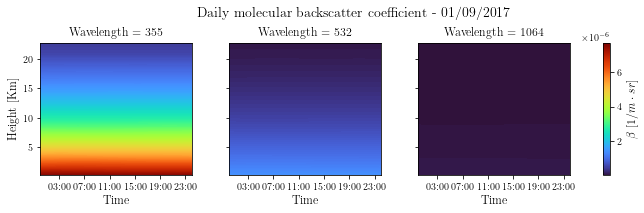

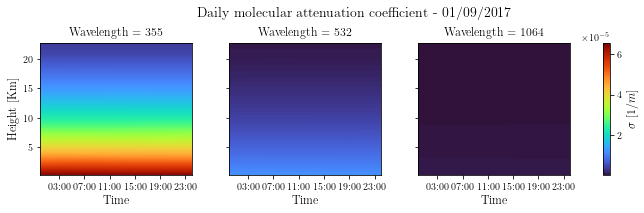

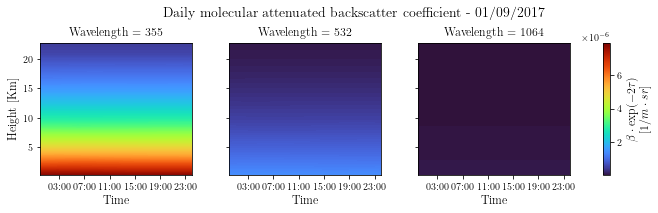

In [13]:
profileTypes = list(ds.data_vars)[:-1]
xfmt = mdates.DateFormatter('%H:%M')
timetics = ds.Time.dt.strftime('%H:%M')
timetics

for row,prof in enumerate(profileTypes):
	ds_var = ds[prof]
	g = ds_var.plot(x='Time',y='Height',col='Wavelength',
	                  col_wrap = 3,cmap = 'turbo')# , figsize = (5,8))
	for ax in g.axes.flat:
		ax.xaxis.set_major_formatter(xfmt)
		ax.xaxis_date()
		ax.get_xaxis().set_major_locator(mdates.HourLocator(interval=4))
		plt.setp( ax.get_xticklabels(), rotation=0,horizontalalignment='center')
		#if row in [0,1]:
		#	ax.xaxis.set_ticklabels([])
		#	ax.set_xlabel(None)
		#if row in [1,2]:
		#	ax.set_title(None)
	plt.suptitle( ds_var.attrs['info']+' - '+ds.attrs['date'][0].strftime('%d/%m/%Y'), y = 1.05)
	#plt.tight_layout()
	plt.show()

In [14]:
df_test_beta = ds.beta.sel(Wavelength=355).to_pandas()
df_test_beta

Time,2017-09-01 00:00:00,2017-09-01 00:00:30,2017-09-01 00:01:00,2017-09-01 00:01:30,2017-09-01 00:02:00,2017-09-01 00:02:30,2017-09-01 00:03:00,2017-09-01 00:03:30,2017-09-01 00:04:00,2017-09-01 00:04:30,...,2017-09-01 23:55:00,2017-09-01 23:55:30,2017-09-01 23:56:00,2017-09-01 23:56:30,2017-09-01 23:57:00,2017-09-01 23:57:30,2017-09-01 23:58:00,2017-09-01 23:58:30,2017-09-01 23:59:00,2017-09-01 23:59:30
Height,,,,,,,,,,,,,,,,,,,,,
0.237750,7.719861e-06,7.719852e-06,7.719843e-06,7.719833e-06,7.719824e-06,7.719815e-06,7.719806e-06,7.719796e-06,7.719786e-06,7.719777e-06,...,7.681570e-06,7.681582e-06,7.681596e-06,7.681610e-06,7.681623e-06,7.681637e-06,7.681650e-06,7.681664e-06,7.681677e-06,7.681690e-06
0.245245,7.715188e-06,7.715179e-06,7.715169e-06,7.715160e-06,7.715150e-06,7.715141e-06,7.715131e-06,7.715122e-06,7.715113e-06,7.715103e-06,...,7.676945e-06,7.676957e-06,7.676970e-06,7.676983e-06,7.676997e-06,7.677009e-06,7.677022e-06,7.677036e-06,7.677048e-06,7.677061e-06
0.252740,7.710514e-06,7.710504e-06,7.710494e-06,7.710484e-06,7.710475e-06,7.710465e-06,7.710455e-06,7.710445e-06,7.710436e-06,7.710426e-06,...,7.672317e-06,7.672330e-06,7.672343e-06,7.672355e-06,7.672367e-06,7.672380e-06,7.672393e-06,7.672405e-06,7.672417e-06,7.672430e-06
0.260234,7.705838e-06,7.705828e-06,7.705818e-06,7.705808e-06,7.705798e-06,7.705788e-06,7.705778e-06,7.705768e-06,7.705758e-06,7.705747e-06,...,7.667689e-06,7.667701e-06,7.667713e-06,7.667725e-06,7.667737e-06,7.667749e-06,7.667761e-06,7.667772e-06,7.667784e-06,7.667797e-06
0.267729,7.701159e-06,7.701148e-06,7.701138e-06,7.701128e-06,7.701117e-06,7.701107e-06,7.701097e-06,7.701087e-06,7.701076e-06,7.701066e-06,...,7.663059e-06,7.663070e-06,7.663081e-06,7.663093e-06,7.663104e-06,7.663116e-06,7.663128e-06,7.663139e-06,7.663150e-06,7.663161e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.684681,4.481957e-07,4.481972e-07,4.481986e-07,4.482001e-07,4.482016e-07,4.482031e-07,4.482046e-07,4.482060e-07,4.482075e-07,4.482090e-07,...,4.473170e-07,4.473143e-07,4.473115e-07,4.473088e-07,4.473061e-07,4.473034e-07,4.473007e-07,4.472979e-07,4.472952e-07,4.472925e-07
22.692176,4.477361e-07,4.477376e-07,4.477391e-07,4.477406e-07,4.477421e-07,4.477435e-07,4.477450e-07,4.477465e-07,4.477480e-07,4.477495e-07,...,4.468545e-07,4.468517e-07,4.468490e-07,4.468463e-07,4.468436e-07,4.468408e-07,4.468381e-07,4.468354e-07,4.468326e-07,4.468299e-07
22.699671,4.472766e-07,4.472781e-07,4.472796e-07,4.472811e-07,4.472826e-07,4.472841e-07,4.472855e-07,4.472870e-07,4.472885e-07,4.472900e-07,...,4.463920e-07,4.463893e-07,4.463865e-07,4.463838e-07,4.463811e-07,4.463783e-07,4.463756e-07,4.463729e-07,4.463701e-07,4.463674e-07


In [15]:
start_time = datetime(2017,9,1,0,30)
end_time = start_time + timedelta(hours = 6) #datetime(2017,9,1,12,30)
timestamps = pd.date_range ( start = start_time , end = end_time  ,
                             freq = timedelta ( seconds = 30 ) )
#slice_beta= mol_xr.loc['beta'].to_pandas().loc[:,timestamps]
print('slicing data set by time')
sub_ds = ds.sel(Time =slice(start_time,end_time))#  timestamps).plot()#=slice(start_time,start_time+timedelta(hours = 6)))

sub_ds

slicing data set by time


<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 721, Wavelength: 3)
Coordinates:
  * Height      (Height) float64 0.2378 0.2452 0.2527 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-01T00:30:00 ... 2017-09-01T06:3...
  * Wavelength  (Wavelength) int64 355 532 1064
Data variables:
    beta        (Wavelength, Height, Time) float32 7.7193035e-06 ... 5.083369...
    sigma       (Wavelength, Height, Time) float32 6.563899e-05 ... 4.317021e-08
    attbsc      (Wavelength, Height, Time) float32 7.954642e-06 ... 5.0850297...
    lambda_nm   (Wavelength) int32 355 532 1064
Attributes:
    info:     Daily molecular profiles
    date:     [datetime.datetime(2017, 9, 1, 0, 0)]

In [16]:
profileTypes = list(ds.data_vars)[:-1]
total_size =0
for prof in profileTypes:
	for wav in ds.Wavelength.values:
		tmp_prof = (ds[prof]).sel(Wavelength=wav).to_pandas()
		cursize = tmp_prof.memory_usage(deep=True).sum()
		print('profile:{}, wavelength: {}, size:{}'.format(prof,wav,humanbytes(cursize)))
		total_size+=cursize

print('total size of data set is at least:{}'.format(humanbytes(total_size)))

'''
# 'sys.getsizeof' is not exactly giving the real size of the dataset, maybe just of the keys? or fields?
print(humanbytes(sys.getsizeof(ds)))
print(humanbytes(sys.getsizeof(ds.coords)))
print(humanbytes(sys.getsizeof(ds.data_vars)))
print(humanbytes(sys.getsizeof(ds.dims)))
'''

profile:beta, wavelength: 355, size:32.98 MB
profile:beta, wavelength: 532, size:32.98 MB
profile:beta, wavelength: 1064, size:32.98 MB
profile:sigma, wavelength: 355, size:32.98 MB
profile:sigma, wavelength: 532, size:32.98 MB
profile:sigma, wavelength: 1064, size:32.98 MB
profile:attbsc, wavelength: 355, size:32.98 MB
profile:attbsc, wavelength: 532, size:32.98 MB
profile:attbsc, wavelength: 1064, size:32.98 MB
total size of data set is at least:296.84 MB


"\n# 'sys.getsizeof' is not exactly giving the real size of the dataset, mabey just of the keys? or fiedls?\nprint(humanbytes(sys.getsizeof(ds)))\nprint(humanbytes(sys.getsizeof(ds.coords)))\nprint(humanbytes(sys.getsizeof(ds.data_vars)))\nprint(humanbytes(sys.getsizeof(ds.dims)))\n"

In [18]:
from netCDF4 import Dataset

month_folder =os.path.join(haifa_station.molecular_src_folder,day_date.strftime('%Y'), day_date.strftime('%m'))
dst_file_name = '{}_molecular.nc'.format(day_date.strftime('%Y_%m_%d'))
ncpath = os.path.join(month_folder,dst_file_name)


if not os.path.exists(month_folder):
    try:
        os.makedirs(month_folder)
    except:
        print('Failed to create folder {dst_path_folder}')


ds.to_netcdf(ncpath,mode= 'w',format= 'NETCDF4')  #TODO: solve to_netcdf() failure

TypeError: illegal data type for attribute b'date', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got O

In [ ]:
data = Dataset(ncpath, mode = 'r')
dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
dataset

In [34]:
day_date = ds.attrs['date'][0]
day_stamp = day_date.strftime('%Y_%m_%d')
month_folder =os.path.join(haifa_station.molecular_src_folder,day_date.strftime('%Y'), day_date.strftime('%m'))
ncpaths=[]
for prof in profileTypes:
	cur_profile = ds[prof]
	for wav in ds.Wavelength.values:
		cur_profile_wav = cur_profile.sel(Wavelength=wav)
		file_name = '{}_{}_{}_molecular.nc'.format(day_stamp,prof,wav)
		ncpath = os.path.join(month_folder,file_name)
		try:
			cur_profile_wav.to_netcdf(ncpath,mode= 'w',format= 'NETCDF4')
		except:
			print('Saving dataset to {} failed', ncpath)

		ncpaths.append(ncpath)
ncpaths

['.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_beta_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_beta_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_beta_1064_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_sigma_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_sigma_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_sigma_1064_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_attbsc_355_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_attbsc_532_molecular.nc',
 '.\\data examples\\molecular_dataset\\2017\\09\\2017_09_01_attbsc_1064_molecular.nc']

In [35]:
data = Dataset(ncpath, mode = 'r')
dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
dataset

<xarray.Dataset>
Dimensions:     (Height: 3000, Time: 2880)
Coordinates:
  * Height      (Height) float64 0.2378 0.2452 0.2527 ... 22.7 22.71 22.71
  * Time        (Time) datetime64[ns] 2017-09-01 ... 2017-09-01T23:59:30
    Wavelength  int64 ...
Data variables:
    attbsc      (Height, Time) float32 ...

In [ ]:
# TODO: solve to_netcdf() failure - for saving dataset to netcdf
# TODO: load netcdf from file
# TODO: split the netcdf to 'beta', 'sigma', 'att_bcs', and to '355','532','1064'
# TODO: check this function for multi dataset savings  xarray.save_mfdataset(): http://xarray.pydata.org/en/stable/generated/xarray.save_mfdataset.html
# TODO: convert from xarray to pytorch

# TODO: validate units of height, speed of light, sigma and beta !!! (km or m)

# TODO: check with Shubi table of samples (for the data loader)
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}

## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.



In [ ]:
bsc_paths, profile_paths = prep.load_att_bsc(lidar_parent_folder, day_date)
bsc_paths
profile_paths


In [ ]:
start_day =  datetime(2019,4,3)
end_day = datetime(2019,4,20)
haifa_station = gs.Station(station_name='haifa')

chunk_paths = prep.convert_periodic_gdas(haifa_station,start_day, end_day)


In [ ]:
import logging
logger = logging.getLogger()

day_dates = pd.date_range(start=start_day, end=end_day, freq=timedelta(days=1))
expected_file_no = len(day_dates) * 8  # 8 timestamps per day
gdastxt_paths = []
for day in day_dates:
    gdastxt_paths.extend(prep.convert_daily_gdas(haifa_station, day))
total_converted = len(gdastxt_paths)
logger.debug(f"Done conversion of {total_converted} gdas files from {start_day.strftime('%Y/%m/%d')} to "
             f"{end_day.strftime('%Y/%m/%d')}, {(expected_file_no - total_converted)} failed.")
